A trader has discovered a source of 1000 unique types of stamps which she can buy in bulk and then sell to a network of 100 merchants through an intermediary. No matter what type of stamp, she pays $1 for each stamp. Each day, she can sell up to 100 bags of stamps (each bag containing one or more different stamps, with no limit on how many stamps can be in each bag),  and she is paid the next day. Unfortunately, the intermediary hides the prices of the individual stamps, and only tells the trader the per-bag price. In order to consistently turn a profit at a reasonable margin, it would be helpful to know which of the 1000 types of stamps are the most valuable, so she could sell bags with only the most valuable stamps. Given 7 days to evaluate 1000 types of stamps using 100 bags/day max, how does she figure out which types of stamps are the most valuable? Please describe two possible approaches, in brief.

In [98]:
import numpy as np
import pandas as pd
import math

In [232]:
## create a list of some random prices using a pareto distribution for some separation
values = np.random.pareto(10, 1000) * 10

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

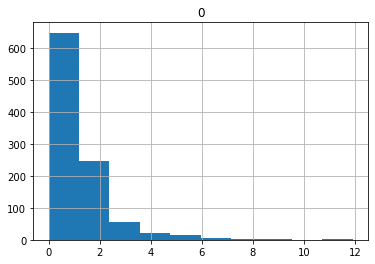

In [233]:
## A few stamps represent the big profit most are not realy worth buying
pd.DataFrame(values).hist()

In [234]:
## create an indice to shuffle around so we can try different 
## sampling without messing up the values hidden to our method
indices = np.array(range(len(values)))

## Brute force -> probablistic small sampling

In [142]:
def grab_best_x(idxs, vals, group_size, best_x):
#     print("index length", len(idxs))
    groups = math.ceil(len(idxs) / group_size)
    arrays = np.array_split(idxs, groups)
    best = {}
    print(len(arrays), [aa.shape for aa in arrays][0], groups)
    for idx in arrays:
        avg = np.mean(vals[idx])
        best[avg] = idx
    top_x = sorted(best)[-best_x:]
    best_indices = []
#     print(top_x, best)
    for x in top_x:
        best_indices.append(best.get(x))
    return np.concatenate(best_indices)

Actual top 20 stamp types

In [236]:
np.sort(values)[-20:]

array([ 5.27503922,  5.31735499,  5.52024094,  5.56997251,  5.68191079,
        5.74055017,  5.79441766,  5.80513494,  5.96130096,  6.31739445,
        6.36461455,  6.38486241,  6.98022371,  7.50833654,  7.61573764,
        7.69044632,  8.56287445,  9.29049733, 10.78542221, 11.91880876])

### 7 Day
7 day brute force, for the first 5 days create 100 bags of 2 stamp types. This will give a value for all stamp types in pairs. Then for the top 100 bags of 2 sample the stamp types individually over 2 days for rank order precision of the top 200 stamps.

In [237]:
remaining_indices = indices
np.random.shuffle(remaining_indices)
remaining_indices = grab_best_x(remaining_indices, values, 2, 100) # 100 groups of 2 over 5 days
remaining_indices = grab_best_x(remaining_indices, values, 1, 20) # 200 groups of 1 over 2 days
print(sorted(values[remaining_indices]))


500 (2,) 500
200 (1,) 200
[5.275039215447926, 5.317354991654923, 5.520240936606829, 5.569972510807535, 5.681910793185128, 5.740550173747225, 5.794417657224768, 5.805134940910723, 5.961300957939977, 6.317394451654628, 6.3646145459885535, 6.384862410253815, 6.98022371041489, 7.508336539869315, 7.615737639854885, 7.690446316517936, 8.56287445479543, 9.290497333157186, 10.785422209880085, 11.918808756929721]


## 5 day
For the first 3 days create 100 bags with 3 or 4 stamp types. Then for the top 50 bags of ~3.34 sample the stamp types individually for 2 days this will rank order stamps that happen to be in the top 50 groups of ~3.34. The more price distribution the better this works but its probabalistic. 

In [238]:
remaining_indices = indices
np.random.shuffle(remaining_indices)
remaining_indices = grab_best_x(remaining_indices, values, 3.34, 50) # 100 groups of 3 to 4 over 3 days
remaining_indices = grab_best_x(remaining_indices, values, 1, 20) # 200 groups of 1 over 2 days
print(sorted(values[remaining_indices]))

300 (4,) 300
162 (1,) 162
[5.275039215447926, 5.317354991654923, 5.520240936606829, 5.569972510807535, 5.681910793185128, 5.740550173747225, 5.794417657224768, 5.805134940910723, 5.961300957939977, 6.317394451654628, 6.3646145459885535, 6.384862410253815, 6.98022371041489, 7.508336539869315, 7.615737639854885, 7.690446316517936, 8.56287445479543, 9.290497333157186, 10.785422209880085, 11.918808756929721]


## 3 day
For the first 2 days create 100 bags with 5 stamps types. Then for the top 20 groups of 5 sample the stamp types individually for 1 days this will rank order stamps that happen to be in the top 20 bags of 5. The more price distribution the better this works. But it is probabalistic and weaker result then 5 day.

In [239]:
remaining_indices = indices
np.random.shuffle(remaining_indices)
remaining_indices = grab_best_x(remaining_indices, values, 5, 20) # 100 groups of 5 over 2 days
remaining_indices = grab_best_x(remaining_indices, values, 1, 20) # 100 groups of 1 over 2 days
print(sorted(values[remaining_indices]))

200 (5,) 200
100 (1,) 100
[3.9060616600508413, 4.056965175158826, 4.5799023178984966, 4.600671037410564, 4.925313962100335, 4.942399646809039, 5.275039215447926, 5.520240936606829, 5.569972510807535, 5.794417657224768, 5.805134940910723, 5.961300957939977, 6.384862410253815, 7.508336539869315, 7.615737639854885, 7.690446316517936, 8.56287445479543, 9.290497333157186, 10.785422209880085, 11.918808756929721]


## Naive Bayes Approach

In [240]:
def build_naive_bayes(idxs, vals, group_size):
#     print("index length", len(idxs))
    groups = math.ceil(len(idxs) / group_size)
    arrays = np.array_split(idxs, groups)
    best = {}
#     print(len(arrays), [aa.shape for aa in arrays][0], groups)
    for idx in arrays:
        avg = np.mean(vals[idx])
        best[avg] = idx
    top_x = sorted(best, reverse=True)
    best_indices = []
#     print(top_x, best)
    for i, x in enumerate(top_x):
        best_indices.append([[ix, i] for ix in best.get(x)])
    return pd.DataFrame(np.concatenate(best_indices), columns=["index", "rank"])

In [241]:
def rank_by_naive_bayes(days, idxs, vals, groups, top_x=20):
    dfs = []
    for day in range(days):
        np.random.shuffle(idxs)
#         print(idxs[:10])
        dfs.append(build_naive_bayes(indices, values, groups))
    df = pd.concat(dfs)
    df["val"] = df["index"].map(lambda x: vals[x])
#     return df
    groups = df.groupby("index")[['rank', "val"]].mean().sort_values(by="rank").head(top_x)
    
    
    return groups

For the naive bayes approach one would create 100 bags of 10 stamp types and shuffle them every day. Capture how the mean value of each bag rank orders and save it as the rank for each stamp type for a given day. Then group by each stamp type and take the mean rank. Given enough data the more valuable stamps will consistently rank lower then the least valuable stamps. 

In [242]:
rank_by_naive_bayes(7, indices, values, 10, 10)

,rank,val
index,,
226,2.000000,10.785422
26,4.571429,11.918809
237,6.285714,8.562874
600,7.714286,7.690446
208,8.857143,7.615738
101,9.000000,6.980224
99,9.142857,9.290497
419,9.285714,5.794418
28,10.142857,6.317394


In [243]:
rank_by_naive_bayes(5, indices, values, 10, 10)

,rank,val
index,,
26,2.0,11.918809
600,3.0,7.690446
226,3.6,10.785422
237,5.0,8.562874
208,6.8,7.615738
671,7.2,4.051392
877,7.4,6.384862
99,10.8,9.290497
140,11.2,2.085729


In [244]:
rank_by_naive_bayes(3, indices, values, 10, 10)

,rank,val
index,,
226,0.000000,10.785422
600,3.666667,7.690446
26,4.333333,11.918809
816,5.000000,4.115546
99,6.000000,9.290497
343,6.000000,4.950087
979,6.666667,1.560184
101,7.000000,6.980224
35,7.000000,0.539743


Being probablistic the naive bayes is decent, but not amazing. However, it is easy to set up.